<a href="https://colab.research.google.com/github/vishnukalyan47/Dogs_vs_Cats_ImageClassifier/blob/main/CatvsDogTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
! pip install -q kaggle

In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishnukalyanledalla","key":"2654b4f96f0693ce0345578517d18c07"}'}

In [7]:
! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18982  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11569  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5951  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           4034  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [11]:
!kaggle datasets download -d chetankv/dogs-cats-images

100% 433M/435M [00:04<00:00, 170MB/s]
100% 435M/435M [00:04<00:00, 107MB/s]


In [12]:
! mkdir train

In [13]:
! unzip dogs-cats-images.zip -d training_set

Streaming output truncated to the last 5000 lines.
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.37.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: training_set/dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: tra

In [14]:
import pathlib
data_dir = pathlib.Path('/content/training_set/dataset/training_set')

In [15]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8000


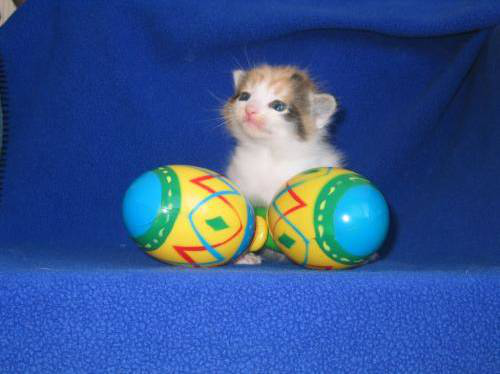

In [16]:
cats = list(data_dir.glob('cats/*'))
PIL.Image.open(str(cats[100]))

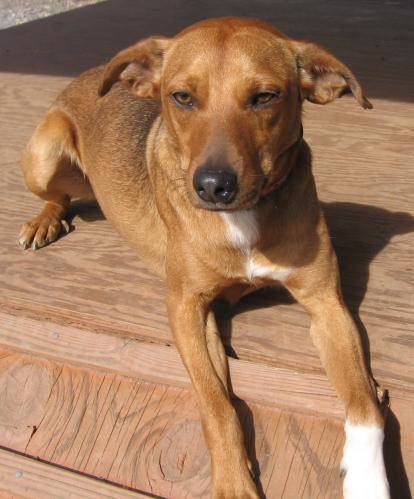

In [17]:
dogs = list(data_dir.glob('dogs/*'))
PIL.Image.open(str(dogs[19]))

In [18]:
batch_size = 32
img_height = 180
img_width = 180

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


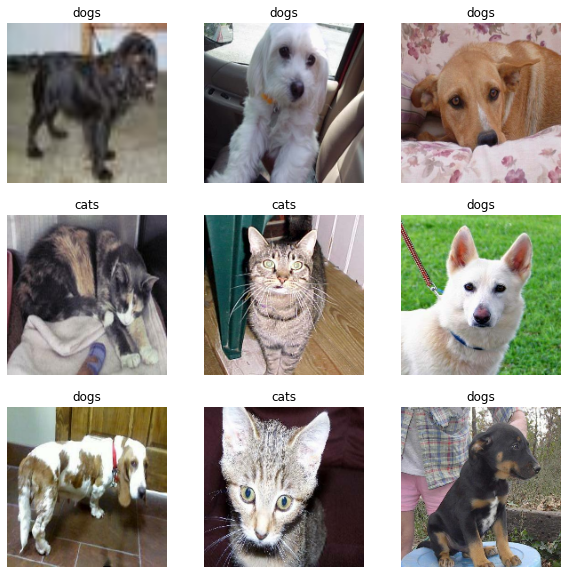

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
normalization_layer = layers.Rescaling(1./255)

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#We can see that the pixel values are now in [0,1].
print(np.min(first_image), np.max(first_image))

0.0 0.93621296


In [26]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [29]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [30]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
200/200 [==============================] - 17s 29ms/step - loss: 0.6590 - accuracy: 0.6005 - val_loss: 0.5851 - val_accuracy: 0.6969
Epoch 2/10
200/200 [==============================] - 4s 21ms/step - loss: 0.5482 - accuracy: 0.7152 - val_loss: 0.5516 - val_accuracy: 0.7269
Epoch 3/10
200/200 [==============================] - 4s 21ms/step - loss: 0.4695 - accuracy: 0.7730 - val_loss: 0.4906 - val_accuracy: 0.7613
Epoch 4/10
200/200 [==============================] - 4s 21ms/step - loss: 0.3996 - accuracy: 0.8163 - val_loss: 0.4870 - val_accuracy: 0.7738
Epoch 5/10
200/200 [==============================] - 4s 21ms/step - loss: 0.3156 - accuracy: 0.8627 - val_loss: 0.5504 - val_accuracy: 0.7513
Epoch 6/10
200/200 [==============================] - 4s 21ms/step - loss: 0.2086 - accuracy: 0.9139 - val_loss: 0.5880 - val_accuracy: 0.7763
Epoch 7/10
200/200 [==============================] - 4s 20ms/step - loss: 0.1276 - accuracy: 0.9473 - val_loss: 0.7499 - val_accuracy: 0.754

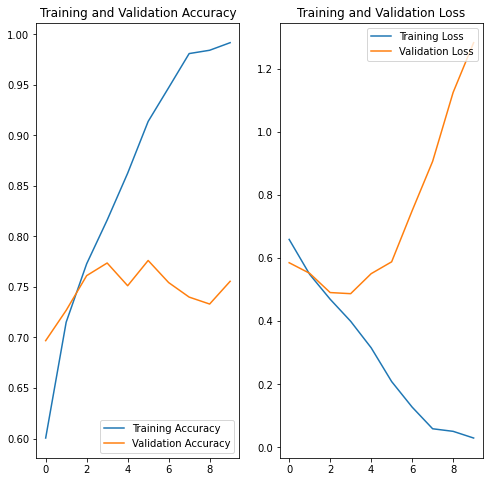

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

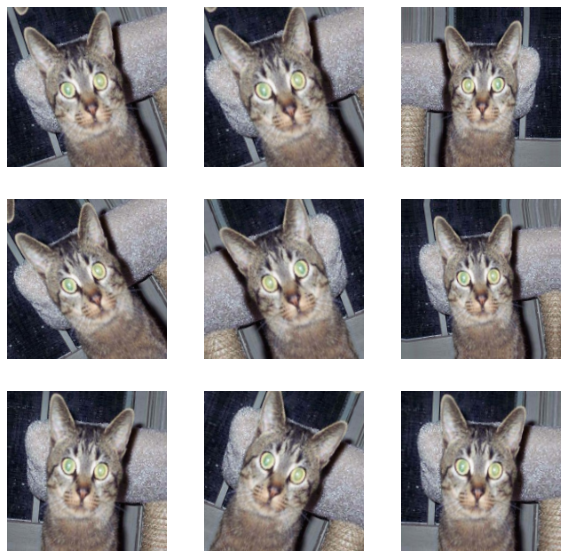

In [33]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [34]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [37]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
200/200 [==============================] - 6s 25ms/step - loss: 0.6962 - accuracy: 0.5477 - val_loss: 0.6762 - val_accuracy: 0.5544
Epoch 2/15
200/200 [==============================] - 5s 24ms/step - loss: 0.6361 - accuracy: 0.6459 - val_loss: 0.6727 - val_accuracy: 0.6200
Epoch 3/15
200/200 [==============================] - 5s 24ms/step - loss: 0.5954 - accuracy: 0.6786 - val_loss: 0.5701 - val_accuracy: 0.7050
Epoch 4/15
200/200 [==============================] - 5s 24ms/step - loss: 0.5541 - accuracy: 0.7145 - val_loss: 0.5486 - val_accuracy: 0.7219
Epoch 5/15
200/200 [==============================] - 5s 24ms/step - loss: 0.5366 - accuracy: 0.7325 - val_loss: 0.5188 - val_accuracy: 0.7444
Epoch 6/15
200/200 [==============================] - 5s 24ms/step - loss: 0.5051 - accuracy: 0.7494 - val_loss: 0.5236 - val_accuracy: 0.7544
Epoch 7/15
200/200 [==============================] - 5s 24ms/step - loss: 0.4850 - accuracy: 0.7667 - val_loss: 0.4895 - val_accuracy: 0.7600

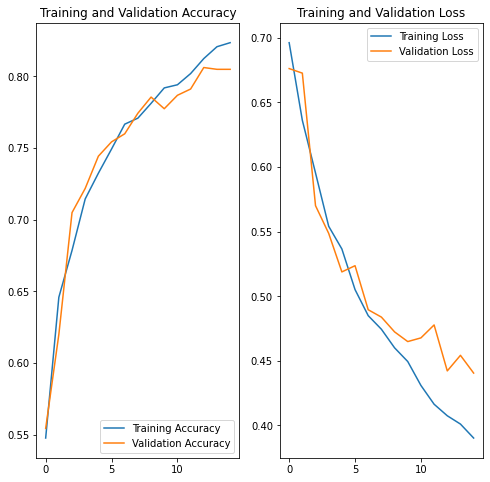

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
test_path = '/content/training_set/dataset/test_set/cats/cat.4018.jpg'
img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to cats with a 91.94 percent confidence.


In [43]:
test_path = '/content/training_set/dataset/test_set/cats/cat.4015.jpg'
img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to cats with a 98.61 percent confidence.


In [45]:
test_path = '/content/training_set/dataset/test_set/dogs/dog.4024.jpg'
img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to dogs with a 84.08 percent confidence.
